<a href="https://colab.research.google.com/github/Andrej-Ilin/practice/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg" />

# Проект: Прогнозирование цены автомобиля на основе его характеристик
#### Проект выполнен октябрь 2022 года
Давайте представим, что в Москве есть компания, которая продает подержанные автомобили. Главная задача компании и ее менеджеров - как можно быстрее находить выгодные предложения (проще говоря, покупать ниже рыночной и продавать выше рыночной цены).

Руководству компании необходимо создать модель, которая будет прогнозировать стоимость автомобиля на основе его характеристик.

Если эта модель работает хорошо, вы сможете быстро выявлять сделки (когда желаемая продавцом цена ниже прогнозируемой рыночной цены). Это значительно ускорит работу ваших менеджеров и увеличит прибыль вашей компании.

Проблема: Исторически сложилось так, что компания не собирала данные с самого начала. Существует лишь небольшой набор данных с коротким периодом истории продаж, чего явно недостаточно для обучения модели. Мы будем использовать его для теста, остальное придется собирать самостоятельно.

### условия и положения:
- Разрешается использовать внешние данные, но их источник должен быть общедоступным и доступным для всех участников (например auto.ru );
- Разрешено использовать любые алгоритмы и библиотеки ML (кроме DL);
Показатель качества модели: MAPE - Средняя Абсолютная Процентная Погрешность.

# 1 Установка и импорт библиотеки

In [1]:
pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.3 MB/s 


In [3]:
# подгрузим стандартные библиотеки
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [4]:
# отключим warnings, чтобы они нам не мешали
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) # Выводим все колонки

## 1.1 Функции для анализа данных

In [5]:
# Расчёт результата модели по метрике MAPE
def mape(y_true, y_pred):
    """
    Рассчитываем среднюю абсолютную процентную ошибку (MAPE).
    
    Средняя абсолютная процентная ошибка (MAPE) - это показатель того, насколько точна система прогнозирования. 
    Она измеряет эту точность в процентах и может быть рассчитана как средняя абсолютная
    процентная ошибка за каждый период времени минус фактические значения, деленные на фактические значения.
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))


def print_df_differences(
    dfs_names: list, 
    dfs: list
):
    """
    Сравниваем наборы данных попарно и выведим уникальные столбцы для каждого 
    набора данных и тип общих столбцов, если они отличаются.
    
    Эта функция принимает список имен фреймов данных (df_names) и самих фреймов 
    данных (dfs). Сравнивая их друг с другом, отобразите список столбцов, 
    которые присутствуют в одном наборе данных и отсутствуют в другом. Он также 
    выводит тип столбцов, которые являются общими для двух наборов данных, если они разные.
    """
    for df in itertools.permutations(zip(dfs_names, dfs)):
        print(f"\nColumns that are present in -{df[0][0]}- dataset and missing in -{df[1][0]}- dataset:")
        print(set(df[0][1].columns).difference(df[1][1].columns))
        for col in set(df[0][1].columns).intersection(df[1][1].columns):
            if df[0][1][col].dtypes != df[1][1][col].dtypes:
                print(f"The common {col} column: {df[0][1][col].dtypes} in -{df[0][0]}- dataset and {df[1][1][col].dtypes} in -{df[1][0]}- dataset")

## 1.2 Импорт данных

Давайте подгрузим данные с Kaggle прямо в Colab, используя API Kaggle.

In [6]:
os.environ['KAGGLE_USERNAME']="andrejilin"
os.environ['KAGGLE_KEY']="237558a6d1366c77d47072cccb1cda72"

Подгружаем датасет.

In [7]:
! kaggle competitions download -c sf-dst-car-price-prediction

 87% 19.0M/21.8M [00:00<00:00, 49.2MB/s]
100% 21.8M/21.8M [00:00<00:00, 51.8MB/s]


Распаковываем подгруженные данные.

In [8]:
! unzip /content/sf-dst-car-price-prediction.zip

Archive:  /content/sf-dst-car-price-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                


In [9]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/modul/skillfactory_rds/modul_6/big_data.csv')

In [10]:
sample_sub = pd.read_csv('/content/sample_submission.csv')

In [11]:
valid = pd.read_csv('test.csv')

# 2 Описание датасета


* bodyType - тип кузова
* brand - марка авто
* car_url - ссылка на объявление
* color - цвет
* complectation_dict - комплектация
* description - описание и реклама
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* equipment_dict - словарь установленного оборудования
* fuelType - тип топлива
* image - ссылка на картинку авто
* mileage - пробег
* modelDate - год модели
* model_info - словарь описания модели
* model_name - имя модели
* name - краткое описание двигателя и мощности
* numberOfDoors - количество дверей
* parsing_unixtime - время сбора данных
* priceCurrency - валюта, в которой указывалась цена
* productionDate - дата выпуска авто
* sell_id - идентифиактор объявления
* super_gen - описание характеристик авто
* vehicleConfiguration - краткое описание привода, кузова и объема двигателя
* vehicleTransmission - тип коробки передач
* vendor - регион производства авто
* Владельцы - количество владельцев
* Владение - срок владения
* ПТС - оригинал/дубликат
* Привод - привод
* Руль - расположение рулевого колеса
* Состояние - состояние авто на момент подачи объявления
* Таможня - авто растаможено в РФ или нет
* Комплектация - словарь с описанием комплектации
* start_date - дата подачи объявления
* hidden - пустой признак в тренировочном датасете

# 3 Предобработка данных и EDA(исследование)

In [12]:
valid.tail(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,"{""id"":""6336008"",""name"":""xDrive20d Локальная сб...",Автомобиль в идеальном состоянии . Куплен новы...,2.0 LTR,184 N12,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,90500,2012,"{""code"":""X1"",""name"":""X1"",""ru_name"":""Х1"",""morph...",X1,20d 2.0d AT (184 л.с.) 4WD,5,1603707909,RUB,2013,1101362518,"{""id"":""8247004"",""name"":""20d"",""nameplate"":""20d""...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
34685,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/11012560...,чёрный,NaN,"Пробег реальный, состояние отличное! Авторска...",3.0 LTR,235 N12,"{""alloy-wheel-disks"":true,""navigation"":true,""p...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,240000,2006,"{""code"":""X5"",""name"":""X5"",""ru_name"":""Х5"",""morph...",X5,30d 3.0d AT (235 л.с.) 4WD,5,1603710264,RUB,2008,1101256068,"{""id"":""20390090"",""name"":""30d"",""nameplate"":""30d...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,6 лет и 1 месяц,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [13]:
train.tail(2)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,price,productionDate,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sell_id,parsing_unixtime
184788,седан,MERCEDES,серебристый,NaN,Машина в хорошем состоянии,1.8 LTR,184 N12,{},бензин,240000.0,2006.0,E_KLASSE,4.0,630000.0,2006.0,"{'id': '20394499', 'name': '200', 'nameplate':...",SEDAN AUTOMATIC 1.8,автоматическая,NaN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,1.102985e+09,1.618712e+09
184789,седан,MERCEDES,чёрный,NaN,"Машина в очень хорошем состоянии, мотор работа...",1.8 LTR,184 N12,"{'cruise-control': True, 'airbag-driver': True...",бензин,134000.0,2006.0,E_KLASSE,4.0,570000.0,2008.0,"{'id': '20394499', 'name': '200', 'nameplate':...",SEDAN AUTOMATIC 1.8,автоматическая,NaN,3 или более,1 год и 2 месяца,Дубликат,задний,Левый,Не требует ремонта,Растаможен,1.103059e+09,1.618712e+09


In [14]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184790 entries, 0 to 184789
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              184710 non-null  object 
 1   brand                 184711 non-null  object 
 2   color                 184711 non-null  object 
 3   complectation_dict    43127 non-null   object 
 4   description           184711 non-null  object 
 5   engineDisplacement    184711 non-null  object 
 6   enginePower           184711 non-null  object 
 7   equipment_dict        184711 non-null  object 
 8   fuelType              184710 non-null  object 
 9   mileage               178119 non-null  float64
 10  modelDate             184710 non-null  float64
 11  model_name            184711 non-null  object 
 12  numberOfDoors         184710 non-null  float64
 13  price                 177046 non-null  float64
 14  productionDate        184711 non-null  float64
 15  

## 3.1. Объединение обучающих и тестовых наборов данных

Чтобы начать предварительную обработку данных и EDA, мне сначала пришлось объединить наши обучающие наборы данных с тестовым. Для этого стоит проверить столбцы, которые присутствуют или отсутствуют в наборах данных, и сравнить типы столбцов.

In [16]:
print_df_differences(dfs_names=['train', 'valid'], dfs=[train, valid])


Columns that are present in -train- dataset and missing in -valid- dataset:
{'price'}
The common sell_id column: float64 in -train- dataset and int64 in -valid- dataset
The common parsing_unixtime column: float64 in -train- dataset and int64 in -valid- dataset
The common numberOfDoors column: float64 in -train- dataset and int64 in -valid- dataset
The common modelDate column: float64 in -train- dataset and int64 in -valid- dataset
The common productionDate column: float64 in -train- dataset and int64 in -valid- dataset
The common mileage column: float64 in -train- dataset and int64 in -valid- dataset

Columns that are present in -valid- dataset and missing in -train- dataset:
{'priceCurrency', 'model_info', 'image', 'name', 'car_url'}
The common sell_id column: int64 in -valid- dataset and float64 in -train- dataset
The common parsing_unixtime column: int64 in -valid- dataset and float64 in -train- dataset
The common numberOfDoors column: int64 in -valid- dataset and float64 in -train

Анализируя данные, представленные выше, можно видеть, что наборs данных отличаются как наличием различных функций, так и типами данных в общих функциях. Для дальнейшей работы все данные должны быть преобразованы в одну и ту же форму.

## 1) Сравнение train и тестовых наборов данных:
В train отсутствуют следующие столбцы по сравнению с тестовым:
- 'image'
- 'priceCurrency'
- 'name'
- 'model_info'
- 'car_url'

##3.2 Уберем не нужные бренды

In [17]:
delit_list = list(set(train.brand.unique()) - set(valid.brand.unique()))
delit_list

['ZX',
 nan,
 'ZOTYE',
 'MAZDA',
 'TIANYE',
 'CITROEN',
 'VORTEX',
 'FAW',
 'ROLLS_ROYCE',
 'IG',
 'ALFA_ROMEO',
 'BRILLIANCE',
 'MASERATI',
 'MCLAREN',
 'TESLA',
 'CHANGAN',
 'GAZ',
 'ZAZ',
 'BENTLEY',
 'HAVAL',
 'FOTON',
 'JEEP',
 'DW_HOWER',
 'DODGE',
 'ARIEL',
 'LOTUS',
 'PONTIAC',
 'SMART',
 'GEELY',
 'ALPINA',
 'MAYBACH',
 'HYUNDAI',
 'CHERYEXEED',
 'ROVER',
 'MG',
 'PEUGEOT',
 'ZIBAR',
 'HAIMA',
 'HAFEI',
 'RINSPEED',
 'OPEL',
 'BRABUS',
 'DADI',
 'LUXGEN',
 'KIA',
 'TIANMA',
 'LAND_ROVER',
 'RAM',
 'LINCOLN',
 'DS',
 'FERRARI',
 'XINKAI',
 'GMC',
 'SAAB',
 'BYD',
 'SUBARU',
 'ASTON_MARTIN',
 'CHRYSLER',
 'PORSCHE',
 'LANCIA',
 'ISUZU',
 'SCION',
 'DATSUN',
 'TAGAZ',
 'JAC',
 'FORD',
 'LIFAN',
 'MERCURY',
 'RAVON',
 'ACURA',
 'FISKER',
 'LIGIER',
 'CHERY',
 'LAMBORGHINI',
 'DAEWOO',
 'CADILLAC',
 'DACIA',
 'HUMMER',
 'GAC',
 'HAWTAI',
 'CHEVROLET',
 'GREAT_WALL',
 'FIAT',
 'GENESIS',
 'IRAN_KHODRO',
 'BUICK',
 'JAGUAR',
 'BAIC',
 'SEAT',
 'SUZUKI',
 'UAZ',
 'PROMO_AUTO',
 'DAIHA

In [18]:
train = train[train['brand'].isin(delit_list) == False]
set(train['brand'].unique()) - set(valid.brand.unique())

set()

## 3.3Смотрим на пропущенные данные

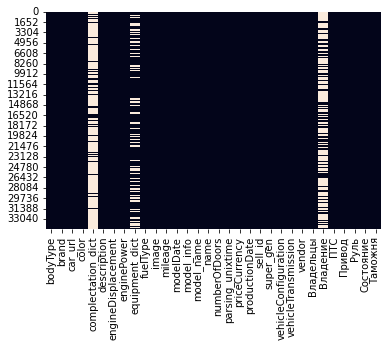

In [19]:
sns.heatmap(valid.isna(), cbar=False)

In [20]:
# смотрим пропущенные значения
valid.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

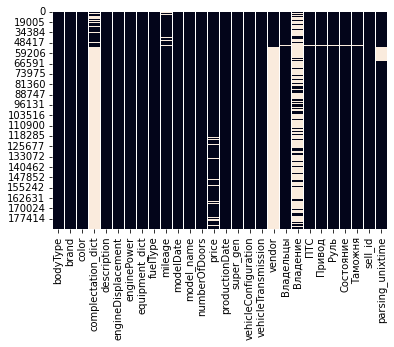

In [21]:
sns.heatmap(train.isna(), cbar=False)

In [22]:
# Сколько пропущенных значений
train.isna().sum()

bodyType                     1
brand                        0
color                        0
complectation_dict      134003
description                  0
engineDisplacement           0
enginePower                  0
equipment_dict               0
fuelType                     1
mileage                   3079
modelDate                    1
model_name                   0
numberOfDoors                1
price                     7611
productionDate               0
super_gen                    1
vehicleConfiguration         1
vehicleTransmission          1
vendor                  129282
Владельцы                  461
Владение                109645
ПТС                        461
Привод                     456
Руль                       455
Состояние                  455
Таможня                    455
sell_id                      0
parsing_unixtime          9671
dtype: int64

In [23]:
# сколько авто продаются за 0 рублей?
train[train['price'] == 0].shape

(1411, 28)

In [24]:
#price - целевая переменная. Строки, в которых она пропущенная, либо равны 0 ценности не имеют. Удаляем их.
train.dropna(subset=['price'], inplace=True)
train = train[train['price'] != 0]
train.shape

(146030, 28)

In [25]:
"""*Добавим parsing_unixtime 1624352882 в train на момент 
скачивания датасета(22.06.2021). Возможно это поможет 
скорректировать изменение цены во времени, если будут загружены новые данные в другое время*"""
# train['parsing_unixtime'] = 1624352882
# train['sell_id'] = 0

'*Добавим parsing_unixtime 1624352882 в train на момент \nскачивания датасета(22.06.2021). Возможно это поможет \nскорректировать изменение цены во времени, если будут загружены новые данные в другое время*'

In [26]:
# смотрим какие колонки отличаются либо не хватает
column_del = list(set(valid.columns) - set(train.columns))
column_del

['name', 'model_info', 'image', 'priceCurrency', 'car_url']

In [27]:
list(set(train.columns) - set(valid.columns))
# в тренировочной лишь только доп столбец с таргетом price

['price']

* 'name - удаляем', т.к. дублируется в др. колонках
* 'model_info' - удаляем, т.к. дублируется в др. колонках
* 'car_url', 
* 'sell_id - **потребуется для соответсвия в valid**, 
*'image', 'priceCurrency' в данном случае не несут смыловой нагрузки.

*удалим лишние колонки из теста*

In [28]:
# Обновим список колонок которые будем удалять
column_del = list(set(valid.columns) - set(train.columns))
display(column_del)
valid = valid.drop(column_del, axis=1)

['name', 'model_info', 'image', 'priceCurrency', 'car_url']

## 3.4 Проверяем на дубликаты

In [29]:
train.duplicated().value_counts()

False    142909
True       3121
dtype: int64

In [30]:
train.loc[train.duplicated()].tail(2)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,price,productionDate,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sell_id,parsing_unixtime
116094,внедорожник 5 дв.,TOYOTA,зелёный,NaN,"Все работет, за исключением омывателя фар(нужн...",4.7 LTR,235 N12,"{'third-row-seats': True, 'alarm': True, 'rear...",бензин,290000.0,1998.0,LAND_CRUISER,5.0,930000.0,2001.0,"{'id': '21285395', 'name': '', 'nameplate': ''...",ALLROAD_5_DOORS AUTOMATIC 4.7,автоматическая,NaN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1.103154e+09,1.618834e+09
116095,универсал 5 дв.,VOLKSWAGEN,зелёный,NaN,Рабочая лошадь. Все вопросы по телефону.,1.8 LTR,75 N12,{},бензин,430000.0,1988.0,PASSAT,5.0,55000.0,1990.0,"{'id': '7866823', 'name': '', 'nameplate': '',...",WAGON_5_DOORS MECHANICAL 1.8,механическая,NaN,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,1.102984e+09,1.618834e+09


In [31]:
# удалим дубли
train.drop_duplicates(inplace=True)

In [32]:
train.shape

(142909, 28)

In [33]:
valid[valid['ПТС'].isna()==True]

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,parsing_unixtime,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
10412,седан,BMW,синий,NaN,"Сделано большое Т.О. Фильтра масляный, воздушн...",2.5 LTR,170 N12,NaN,бензин,276000,1998,3ER,4,1603118960,1999,33504008,"{""id"":""6329491"",""name"":""323"",""nameplate"":""323i...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,NaN,задний,Левый,Не требует ремонта,Растаможен


In [34]:
valid['ПТС'].fillna(3, inplace=True)

### Объединяем данные

In [35]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # Помечаем трейн
valid['sample'] = 0
valid['price'] = 0 #добавляем не достающий столбец.
frames = [train, valid]
data = pd.concat(frames, ignore_index=True)

In [36]:
data.shape

(177595, 29)

##3.5 Удалим не иформативные признаки.
- 'complectation_dict' - удалим. слишком много пропущенных значений, но можно попробовать вытащить значимые слова.
- 'description' - удалим. можно попробовать вытащить значимые слова.
- 'vehicleConfiguration' - перевести в некое векторное пространство и разложить по векторам.
- 'equipment_dict', 
-'super_gen', 
-'Владение'

In [37]:
# Удалим не иформативные признаки
data = data.drop(columns=['complectation_dict', 'description', 'vehicleConfiguration', 'equipment_dict', 'super_gen', 'Владение', 'vendor', 'parsing_unixtime'])

# Работа с пропусками

In [38]:
# Удалим строки с пропусками
# data.dropna(axis=0, thresh=617, inplace=True)
display(data.isna().sum())

bodyType                  1
brand                     0
color                     0
engineDisplacement        0
enginePower               0
fuelType                  1
mileage                2779
modelDate                 1
model_name                0
numberOfDoors             1
price                     0
productionDate            0
vehicleTransmission       1
Владельцы               404
ПТС                     405
Привод                  400
Руль                    399
Состояние               399
Таможня                 399
sell_id                   0
sample                    0
dtype: int64

* ПТС можно заполнить по условию: если пробег == 0, то ПТС оригинал, если большой пробег, то пишем дубликат.
* milage - заполнить в средним исходя из возраста авто по n тыс. км в год - для этого выведем среднестатистический пробег за год используя группирорвку.

In [39]:
# Сгрупируем по годам и выведем средний пробег
Frame_mileage = train.pivot_table(values='mileage', index='productionDate', aggfunc='mean')
Frame_mileage

,mileage
productionDate,
1934.0,25000.000000
1937.0,9003.333333
1938.0,60173.333333
1939.0,383333.000000
1940.0,92500.000000
...,...
2017.0,77520.978435
2018.0,57657.584660
2019.0,32471.940070


In [40]:
int(Frame_mileage.loc[2003])

251971

In [41]:
# Заполним пропуски по условия количества лет автомобилю и добавим среднее исходя из возраста авто.
for y in (Frame_mileage.index):
  data.mileage = np.where((pd.isnull(data['mileage'])) & (data['productionDate'] == y), int(Frame_mileage.loc[y]), data['mileage']) # см. numpy.where()

In [42]:
data.shape

(177595, 21)

In [43]:
# Чистим от остальных не значительных пропусков
data.dropna(inplace=True )
data.reset_index(inplace=True, drop=True)

In [44]:
data.isna().sum()

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
price                  0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
Состояние              0
Таможня                0
sell_id                0
sample                 0
dtype: int64

## Работа с числовыми признаками
*главное условие правильной нормализации — все признаки должны быть равны в возможностях своего влияния. [статья на habr](https://habr.com/ru/post/527334/).*
- определяем смещение и респределение признаков
- корректируем выбросы
- масштабируем
Оцениваем выбросы. В помошь я использовал одну из статей на Хабре. https://habr.com/ru/post/578754/

In [45]:
# Выделим список числовых признаков.
int_columns = data.select_dtypes(include=['float64', 'int64']).columns
int_columns

Index(['mileage', 'modelDate', 'numberOfDoors', 'price', 'productionDate',
       'sell_id', 'sample'],
      dtype='object')

- *enginePower, engineDisplacement необходимо перевести в float*

In [46]:
data['enginePower'].value_counts()

150 N12    9319
249 N12    7512
110 N12    4818
105 N12    4630
170 N12    4252
           ... 
52.0          1
72.0          1
187.0         1
530.0         1
480 N12       1
Name: enginePower, Length: 776, dtype: int64

In [47]:
data['enginePower'] = data['enginePower'].apply(lambda x: float(str(x).replace(' N12', '')))

In [48]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: (str(x).replace(' LTR"', '')))
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: (str(x).replace(' LTR', '')))
data['engineDisplacement'] = data['engineDisplacement'].replace(r'', '0.0')
data['engineDisplacement'] = data['engineDisplacement'].astype(float)

In [49]:
data[data['engineDisplacement'] == 0.0].head(3) # Объем ДВС == 0 это электрокары

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,price,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,sell_id,sample
6694,хэтчбек 5 дв.,NISSAN,белый,0.0,109.0,электро,44000.0,2010.0,LEAF,5.0,70000.0,2010.0,автоматическая,2 владельца,Оригинал,передний,Правый,Не требует ремонта,Растаможен,0.0,1
7814,хэтчбек 5 дв.,MITSUBISHI,серебристый,0.0,67.0,электро,95000.0,2009.0,I_MIEV,5.0,50000.0,2011.0,автоматическая,1,Оригинал,задний,Левый,Не требует ремонта,Растаможен,0.0,1
7834,хэтчбек 5 дв.,NISSAN,красный,0.0,109.0,электро,55000.0,2010.0,LEAF,5.0,10000.0,2011.0,автоматическая,1,Оригинал,передний,Правый,Не требует ремонта,Растаможен,0.0,1


### Определяем смещение и респределение признаков

In [50]:
float_columns = ['engineDisplacement', 'enginePower', 'mileage', 'price'] 


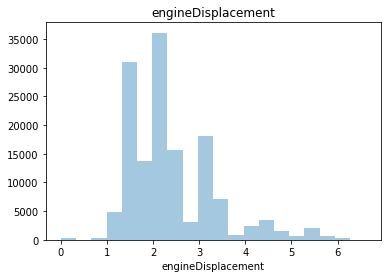

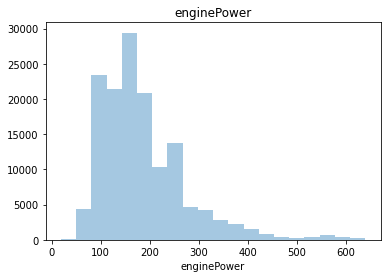

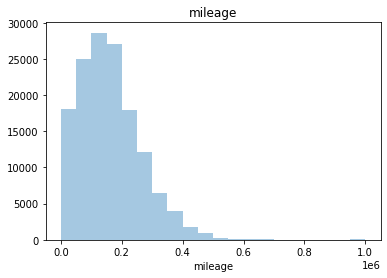

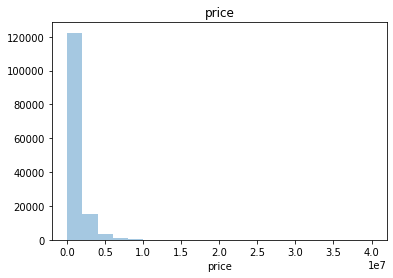

In [51]:
for i in float_columns:
    plt.figure()
    sns.distplot(data[data['sample'] == 1][i], kde = False, rug=False, bins=20)
    plt.title(i)
    plt.show()

### Корректируем выбросы


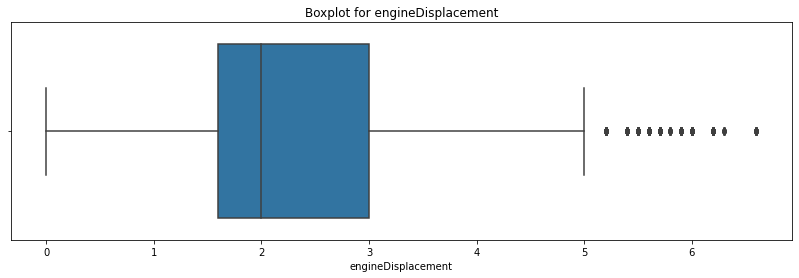

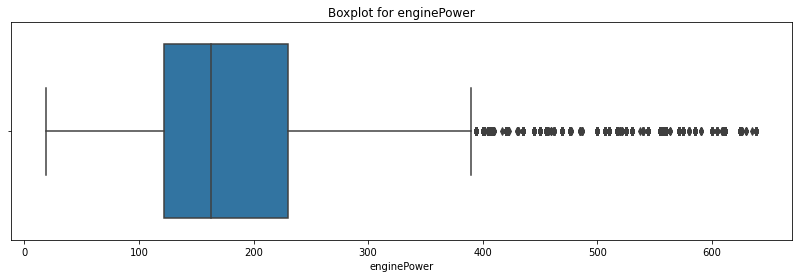

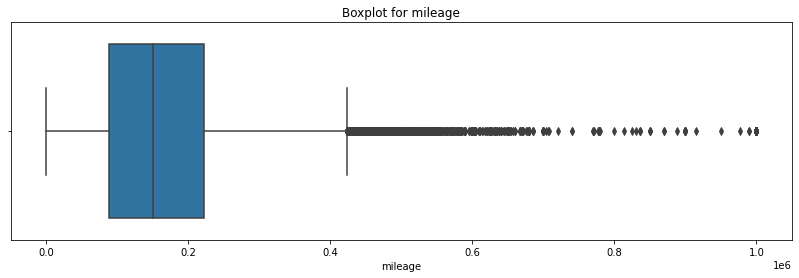

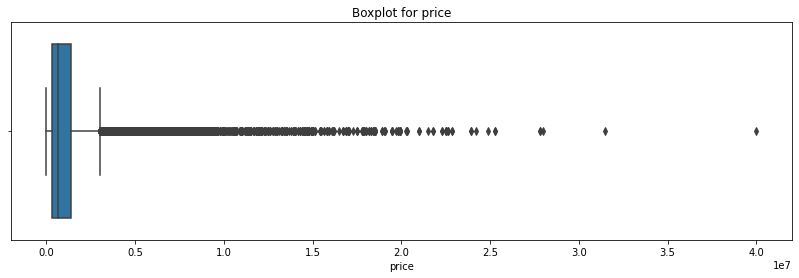

In [52]:
"""Строим графики чтобы посмотреть в каких столбцах у нас есть выбросы."""
for column in float_columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column,
                data=data[data['sample'] == 1],
                ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

*Используем стандартное удаление выбросов*

In [53]:
# columns = float_columns
# for column in columns:
#   Q1 = np.percentile(data[column], 25,
#                      interpolation = 'midpoint')
  
#   Q3 = np.percentile(data[column], 75,
#                      interpolation = 'midpoint')
#   IQR = Q3 - Q1
#   border_upper = Q3+1.5*IQR
#   border_lower = Q1-1.5*IQR
#   # upper = np.where(data[data['sample'] == 1][column] >= border_upper) # выделяем по индексам 
#   # data.loc[upper[0], column] = border_upper # upper[0] - массив индексов 
#   data.loc[(data[column] >= border_upper), (column)] = border_upper
#   # Lower bound
#   # lower = np.where(data[data['sample'] == 1][column] <= border_lower)
#   # data.loc[lower[0], column] = border_lower
#   data.loc[(data[column] <= border_lower), (column)] = border_lower
#   print(column, border_lower, border_upper)
# try:
#   data.drop(columns='index', inplace=True) # Удалим появившийся дубликат индекса
# except:
#   pass

In [54]:
# for column in float_columns:
#     fig, ax = plt.subplots(figsize=(14, 4))
#     sns.boxplot(x=column,
#                 data=data[data['sample'] == 1],
#                 ax=ax)
#     plt.xticks(rotation=0)
#     ax.set_title('Boxplot for ' + column)
#     plt.show()

### масштабируем

In [55]:
# по скольку в объедененном датасете есть данные на валидацию не имеющие price, отделим на время для анализа.
train_preproc = data[data['sample'] == 1]

In [56]:
train_preproc.describe()

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,price,productionDate,sell_id,sample
count,142499.000000,142499.000000,142499.000000,142499.000000,142499.000000,1.424990e+05,142499.000000,1.424990e+05,142499.0
mean,2.352435,184.785486,164364.537456,2007.331125,4.478354,1.103863e+06,2009.456972,9.175006e+08,1.0
std,0.948911,88.056865,104268.587401,7.852765,0.677254,1.406048e+06,7.544713,4.103925e+08,0.0
min,0.000000,19.000000,1.000000,1934.000000,2.000000,2.700000e+01,1934.000000,0.000000e+00,1.0
25%,1.600000,122.000000,87800.000000,2003.000000,4.000000,3.100000e+05,2006.000000,1.096948e+09,1.0
50%,2.000000,163.000000,150000.000000,2009.000000,5.000000,6.900000e+05,2011.000000,1.102538e+09,1.0
75%,3.000000,230.000000,222222.000000,2013.000000,5.000000,1.390000e+06,2015.000000,1.103010e+09,1.0
max,6.600000,639.000000,1000000.000000,2020.000000,5.000000,4.000000e+07,2021.000000,1.103342e+09,1.0


Смотрим на распределение таргета до и после логарифмировние - по идее последнее должно немного отцентровать распределение.

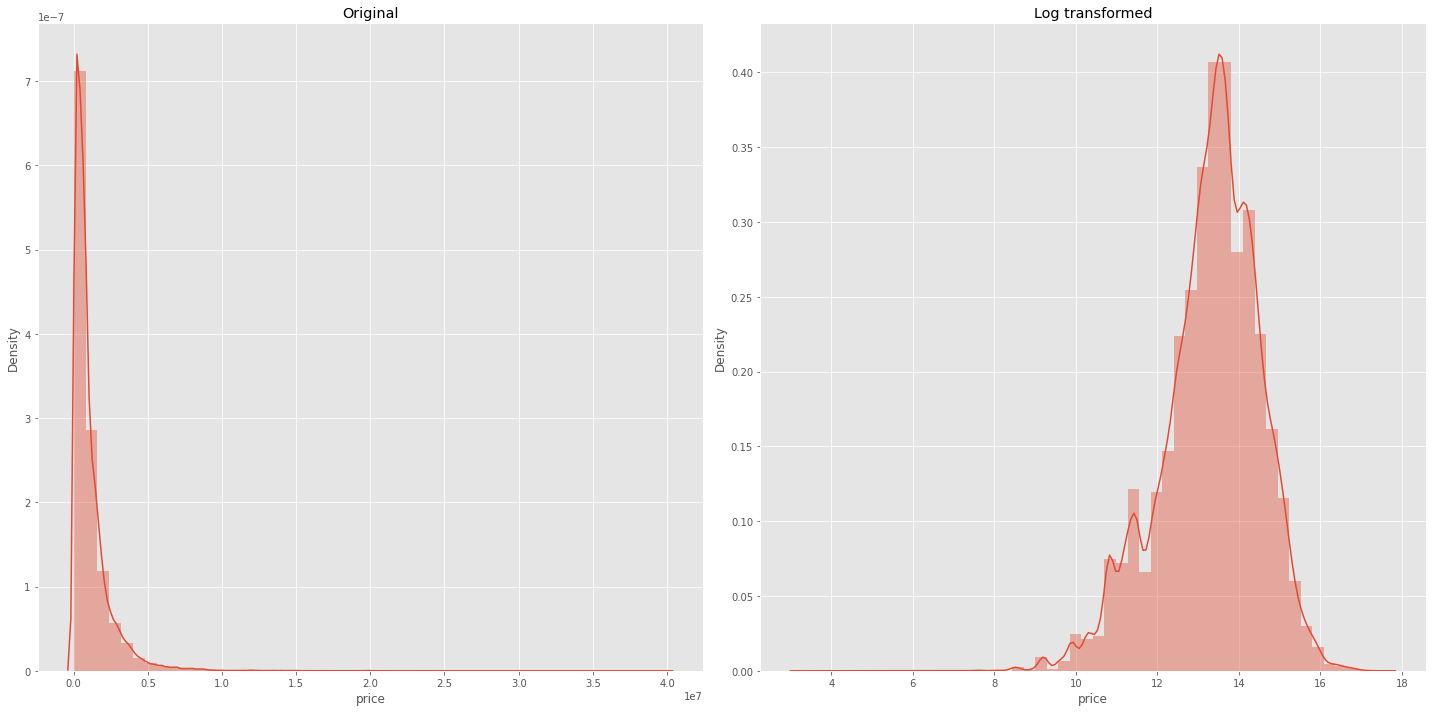

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(train_preproc.price, bins=50)
plt.title('Original')

plt.subplot(1,2,2)
sns.distplot(np.log1p(train_preproc.price), bins=50) # тоже что и np.log(data.price+1)
plt.title('Log transformed')

plt.tight_layout()

Чтобы понять насколько хорошее распределение я использовал QQ-plot из статьи https://habr.com/ru/post/578754

Text(0, 0.5, 'Sample quantiles')

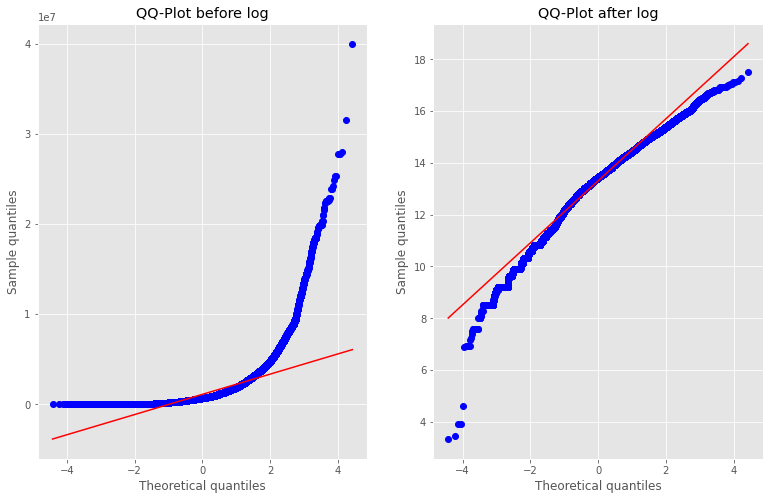

In [58]:
##QQ-Plot before log-transformation
fig = plt.figure(figsize=(13, 8))

ax1 = plt.subplot(121)
res = stats.probplot(train_preproc['price'], plot=plt)
plt.title('QQ-Plot before log')
plt.ylabel('Sample quantiles')

ax1 = plt.subplot(122)
a = np.log1p(train_preproc["price"])
res = stats.probplot(a, plot=plt)
plt.title('QQ-Plot after log')
plt.ylabel('Sample quantiles')

# Категориальные признаки


In [59]:
# Выделем признаки object
object_columns = data.select_dtypes(include=['object']).columns
object_columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'model_name',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня'],
      dtype='object')

In [60]:
# Выведем количество 
for col in object_columns:
  print('Колонка---', col)
  print(data[col].value_counts())
  print('всего -- видов', data[col].value_counts().count())
  print()

Колонка--- bodyType
седан                      65923
внедорожник 5 дв.          63291
хэтчбек 5 дв.              12179
лифтбек                    10050
универсал 5 дв.             6898
минивэн                     5257
купе                        3792
компактвэн                  3138
хэтчбек 3 дв.               2095
пикап двойная кабина        1561
купе-хардтоп                 829
фургон                       653
внедорожник 3 дв.            594
родстер                      333
кабриолет                    279
седан-хардтоп                195
микровэн                      35
седан 2 дв.                   24
пикап полуторная кабина       20
пикап одинарная кабина        16
лимузин                       11
внедорожник открытый           5
тарга                          5
универсал 3 дв.                1
фастбек                        1
Name: bodyType, dtype: int64
всего -- видов 25

Колонка--- brand
MERCEDES      24142
VOLKSWAGEN    23491
BMW           22974
TOYOTA        22887
NISSAN    

*Колонка bodyType дополнительно указано кол-во дверей, что увеличивает разновидность. Поскольку у нас есть отдельная колонка numberOfDoors значит можно объеденить некоторые разновидности кузова в bodyType.*

In [61]:
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).replace(' 2 дв.', ''))
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).replace(' 3 дв.', ''))
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).replace(' 4 дв.', ''))
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).replace(' 5 дв.', ''))

*Колонка 'Владельцы' имеет значения '1' и '1 владелец' - объеденим их*

In [62]:
data[data['Владельцы'] == '1 владелец'] # не находит

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,price,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,sell_id,sample


In [63]:
data['Владельцы'].value_counts().index[3]

'1'

In [64]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: str(x).replace('1\xa0владелец', '1'))

In [65]:
data.loc[data['ПТС'] == 3, 'ПТС'] = 'Оригинал'

* "Руль" и "ПТС" имеет бинарный признак.
"Таможня" и "состояние" как втрейн так и в валидции имеет только одно значение - они бесполезны.*

In [66]:
data = data.drop(columns=["Таможня", "Состояние"]) # удалим
object_columns = data.select_dtypes(include=['object']).columns # список
object_columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'model_name',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль'],
      dtype='object')

## Бинарные признаки

In [67]:
# бинарные признаки 
bin_cols = ["Руль","ПТС"]
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data[bin_cols].head()

,Руль,ПТС
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [68]:
data['ПТС'].value_counts()

1    150006
0     27179
Name: ПТС, dtype: int64

In [69]:
# ohe = OneHotEncoder()
object_OH = ['color', 'fuelType', 'vehicleTransmission', 'vendor', 'Привод']
data_dummies = pd.get_dummies(data=data[object_OH], prefix=['color', 'fuelType', 'vehicleTransmission', 'vendor', 'Привод'], drop_first=True)

KeyError: ignored

In [ ]:
data_new = pd.concat([data, data_dummies], axis=1)

In [ ]:
data_dummies.shape, data.shape, data_new.shape

In [ ]:
data_new.drop(columns=object_OH, inplace=True)

In [ ]:
object_LE = ['Владельцы']
label_encoder = LabelEncoder()
for column in object_LE:
    data_new[column] = label_encoder.fit_transform(data_new[column])
    
# убедимся в преобразовании    
data_new[object_LE].value_counts() 

*Ранжирование не поменялось "3 или более" = 36960, '1'= 28008, '2'=владельца'= 23963*

## Taget_encoder

Признаки bodyType,	brand и model_name - выполним ранжирование исходя из таргета. 

*Важно перед тем как использовать target_encoder нужно разделить наш датасет на тренировочную и тестовую, т.к. этот метод использует целевую переменную и может произоцти утечка данных в обучающую выборку.*

In [ ]:
data_new.shape

In [ ]:
pip install category_encoders

In [ ]:
# Делим датасет на трейн, тест и валидацию
RANDOM_SEED = 42
train_pred = data_new[data_new['sample'] == 1].drop(['sample'], axis=1).reset_index(drop=True)
valid_pred = data_new[data_new['sample'] == 0].drop(['sample', 'price'], axis=1).reset_index(drop=True)
X = train_pred.drop(columns=['price'])
Y = train_pred['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [ ]:
import category_encoders as ce
object_TE = ['bodyType', 'brand', 'model_name', ]
for col in object_TE:
  enc = ce.TargetEncoder(cols=col)
  X_train[col] = enc.fit_transform(X_train[col], y_train)
  X_test[col] = enc.transform(X_test[col])
  valid_pred[col] = enc.transform(valid_pred[col])

In [ ]:
# df_cum = pd.DataFrame({'bodyType': ['седан', 'универсал', 'купе'],'brand': ['лада', 'bmw', 'mercedes'],'price': [120000, 300000, 999999]})
# from category_encoders import TargetEncoder
# encoder = TargetEncoder( )
# obj_TE = ['bodyType', 'brand']
# df_cum['enc_bodyType'] = encoder.fit_transform(df_cum['bodyType'], df_cum['price'])
# df_cum

In [ ]:
# 130.54%
# object_TE = ['bodyType', 'brand', 'model_name', ]
# label_encoder = LabelEncoder()
# for column in object_TE:
#     data_new[column] = label_encoder.fit_transform(data_new[column])
    
# # убедимся в преобразовании    
# data_new[object_TE].value_counts() 

# Стандартизация признаков

In [ ]:
X_train.loc[:, ~X_train.columns.isin(['sell_id'])]

In [ ]:
SS = StandardScaler()
X_train_trans = SS.fit_transform(X_train.loc[:, ~X_train.columns.isin(['sell_id'])])
X_test_trans = SS.transform(X_test.loc[:, ~X_train.columns.isin(['sell_id'])])
valid_trans =  SS.transform(valid_pred.loc[:, ~valid_pred.columns.isin(['sell_id'])]) 

In [ ]:
X_train_trans = X_train.loc[:, ~X_train.columns.isin(['sell_id'])]
X_test_trans = X_test.loc[:, ~X_train.columns.isin(['sell_id'])]

In [ ]:
y_train

# Создание наивной предсказательной модели 

In [ ]:
lr = LinearRegression().fit(X_train_trans, y_train)

In [ ]:
y_pred = lr.predict(X_test_trans)

In [ ]:
#оцениваем точность
m = mape(y_test, y_pred)
print(f"Точность модели по метрике MAPE: {m}%")

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [ ]:
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

In [ ]:
model_cb = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model_cb.fit(X_train_trans, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test_trans, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )
# оцениваем точность
predict = model_cb.predict(X_test_trans)
m = mape(y_test, predict)
print(f"Точность модели по метрике MAPE: {m}%")

In [ ]:
# print(f"Точность модели по метрике MAPE: {m}%")